<a href="https://colab.research.google.com/github/tallerzalan/Applied-Machine-Learning/blob/main/NNs/Exercise_7_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Oct 30 16:24:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    48W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


# Exercise - CNNs

1. Use the CIFAR-10 data. Build a CNN with no more than 50,000 parameters (**hint**: think carefully on how to use pooling to downscale and on the number of filters of convolutional layers). A model of this size should still be able to perform quite well on the CIFAR-10 data. You may want to explore even smaller models.
1. Build a model using 10 convolutional layers with kernel size (5, 5) (**hint**: proper use of padding is crucial to make this possible). 
1. Attempt to improve the performance of your models by using image augmentation. Consider which types of augmentations make sense to use. Recall how you may want to use a larger model and/or train for longer now that you use augmentation.
1. Try to use what we learned during our last lecture (on regularization and optimization) to improve your model.

**Note**: You may want to use:
1. https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
1. https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D
1. https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing **OR** https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

**See slides for more details!**

# Exercise 1

Use the CIFAR-10 data. Build a CNN with no more than 50,000 parameters (**hint**: think carefully on how to use pooling to downscale and on the number of filters of convolutional layers). A model of this size should still be able to perform quite well on the CIFAR-10 data. You may want to explore even smaller models.

**Setup**

In [4]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator

170498071/170498071 [==============================] - 2s 0us/step
Training data shape: ((50000, 32, 32, 3), (50000, 1))
Testing data shape: ((10000, 32, 32, 3), (10000, 1))
Total number of outputs: 10
Output classes: [0 1 2 3 4 5 6 7 8 9]


Text(0.5, 1.0, 'Ground Truth: [3]')

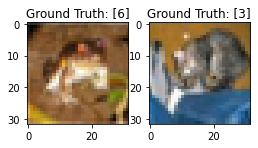

In [5]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

print(f'Training data shape: {train_images.shape, train_labels.shape}')
print(f'Testing data shape: {test_images.shape, test_labels.shape}')

# Find the unique numbers from the train labels
classes = np.unique(train_labels)
nClasses = len(classes)
print(f'Total number of outputs: {nClasses}')
print(f'Output classes: {classes}')

plt.figure(figsize = [4,2])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_images[0, :, :],
           cmap = 'gray')
plt.title('Ground Truth: {}'.format(train_labels[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_images[0, :, :],
           cmap = 'gray')
plt.title('Ground Truth: {}'.format(test_labels[0]))

In [6]:
nRows, nCols, nDims = train_images.shape[1:]
train_data = train_images.reshape(train_images.shape[0], nRows, nCols, nDims)
test_data = test_images.reshape(test_images.shape[0], nRows, nCols, nDims)
input_shape = (nRows, nCols, nDims)

train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

train_data /= 255
test_data /= 255

train_labels_one_hot = to_categorical(train_labels)
test_labels_one_hot = to_categorical(test_labels)

print(f'Original label 0: {train_labels[0]}')
print(f'After conversion to categorical (one-hot): {train_labels_one_hot[0]}')

Original label 0: [6]
After conversion to categorical (one-hot): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [7]:
def createSmallModel():
    model = Sequential()

    # The first two layers with 32 filters of window size 3x3
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = input_shape))
    model.add(MaxPooling2D(pool_size = (3, 3)))

    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (3, 3)))
    
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(nClasses, activation = 'softmax'))
    
    return model

In [8]:
model_small = createSmallModel()

batch_size = 128
epochs = 20

model_small.compile(optimizer = 'rmsprop',
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

model_small.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                1

In [9]:
history_small = model_small.fit(train_data,
                                train_labels_one_hot,
                                batch_size = batch_size,
                                epochs = epochs,
                                verbose = 1,
                                validation_data = (test_data, test_labels_one_hot))

model_small.evaluate(test_data,
                     test_labels_one_hot)

Epoch 1/20
391/391 [==============================] - 12s 6ms/step - loss: 1.8604 - accuracy: 0.3240 - val_loss: 1.6870 - val_accuracy: 0.3973
Epoch 2/20
391/391 [==============================] - 2s 5ms/step - loss: 1.5488 - accuracy: 0.4448 - val_loss: 1.5019 - val_accuracy: 0.4546
Epoch 3/20
391/391 [==============================] - 2s 5ms/step - loss: 1.4071 - accuracy: 0.5028 - val_loss: 1.3542 - val_accuracy: 0.5145
Epoch 4/20
391/391 [==============================] - 2s 5ms/step - loss: 1.3152 - accuracy: 0.5384 - val_loss: 1.2601 - val_accuracy: 0.5563
Epoch 5/20
391/391 [==============================] - 2s 4ms/step - loss: 1.2448 - accuracy: 0.5637 - val_loss: 1.3322 - val_accuracy: 0.5329
Epoch 6/20
391/391 [==============================] - 2s 5ms/step - loss: 1.1916 - accuracy: 0.5836 - val_loss: 1.2328 - val_accuracy: 0.5656
Epoch 7/20
391/391 [==============================] - 2s 5ms/step - loss: 1.1498 - accuracy: 0.5969 - val_loss: 1.1854 - val_accuracy: 0.5866
Epoch

[1.0926408767700195, 0.6309000253677368]

# Exercise 2

Build a model using 10 convolutional layers with kernel size (5, 5) (**hint**: proper use of padding is crucial to make this possible). 

In [10]:
def createLargeModel():
    model = Sequential()

    # The first two layers with 32 filters of window size 3x3
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'same', activation = 'relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))

    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))
    
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))

    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))

    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(nClasses, activation = 'softmax'))
    
    return model

In [11]:
model_large = createLargeModel()

batch_size = 128
epochs = 20

model_large.compile(optimizer = 'rmsprop',
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

model_large.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        2432      
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        25632     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        51264     
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        102464    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                  

In [12]:
history_large = model_large.fit(train_data,
                                train_labels_one_hot,
                                batch_size = batch_size,
                                epochs = epochs,
                                verbose = 1,
                                validation_data = (test_data, test_labels_one_hot))

model_large.evaluate(test_data,
                     test_labels_one_hot)

Epoch 1/20
391/391 [==============================] - 6s 11ms/step - loss: 2.2872 - accuracy: 0.1663 - val_loss: 2.0635 - val_accuracy: 0.2169
Epoch 2/20
391/391 [==============================] - 4s 10ms/step - loss: 1.8253 - accuracy: 0.3163 - val_loss: 1.5898 - val_accuracy: 0.4144
Epoch 3/20
391/391 [==============================] - 4s 10ms/step - loss: 1.5596 - accuracy: 0.4266 - val_loss: 1.5470 - val_accuracy: 0.4472
Epoch 4/20
391/391 [==============================] - 4s 10ms/step - loss: 1.3413 - accuracy: 0.5233 - val_loss: 1.3267 - val_accuracy: 0.5240
Epoch 5/20
391/391 [==============================] - 4s 10ms/step - loss: 1.1581 - accuracy: 0.5950 - val_loss: 1.2393 - val_accuracy: 0.5830
Epoch 6/20
391/391 [==============================] - 4s 10ms/step - loss: 1.0156 - accuracy: 0.6497 - val_loss: 0.9900 - val_accuracy: 0.6632
Epoch 7/20
391/391 [==============================] - 4s 10ms/step - loss: 0.8940 - accuracy: 0.6944 - val_loss: 1.4862 - val_accuracy: 0.5834

[1.1917320489883423, 0.7186999917030334]

# Exercise 3

Attempt to improve the performance of your models by using image augmentation. Consider which types of augmentations make sense to use. Recall how you may want to use a larger model and/or train for longer now that you use augmentation.

Start by considering which approach to image augmentation you want to use. I recommend using the approach in https://www.tensorflow.org/api_docs/python/tf/keras/layers and building it directly as a layer of your network.

You may also want to read https://www.tensorflow.org/tutorials/images/data_augmentation for more tips.

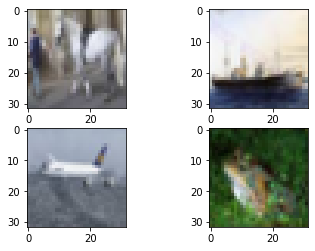

In [13]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

datagen = ImageDataGenerator()
datagen.fit(X_train)

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size = 4, seed = 42):
  for i in range(0, 4):
    plt.subplot(220 + 1 + i)
    plt.imshow(X_batch[i])
  plt.show()
  break

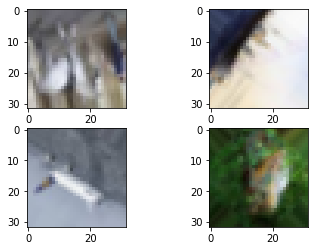

In [14]:
datagen = ImageDataGenerator(rotation_range = 359)
datagen.fit(X_train)

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size = 4, seed = 42):
  for i in range(0, 4):
    plt.subplot(220 + 1 + i)
    plt.imshow(X_batch[i])
  plt.show()
  break

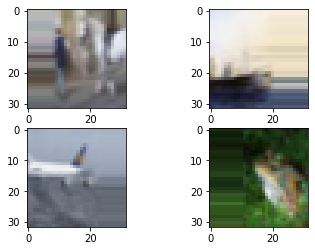

In [15]:
datagen = ImageDataGenerator(height_shift_range = 0.5)
datagen.fit(X_train)

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size = 4, seed = 42):
  for i in range(0, 4):
    plt.subplot(220 + 1 + i)
    plt.imshow(X_batch[i])
  plt.show()
  break

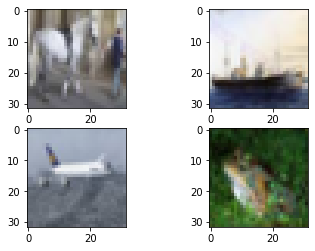

In [16]:
datagen = ImageDataGenerator(horizontal_flip = True)
datagen.fit(X_train)

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size = 4, seed = 42):
  for i in range(0, 4):
    plt.subplot(220 + 1 + i)
    plt.imshow(X_batch[i])
  plt.show()
  break

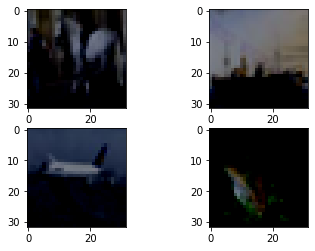

In [17]:
datagen = ImageDataGenerator(featurewise_center = True)
datagen.fit(X_train)

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size = 4, seed = 42):
  for i in range(0, 4):
    plt.subplot(220 + 1 + i)
    plt.imshow(X_batch[i])
  plt.show()
  break

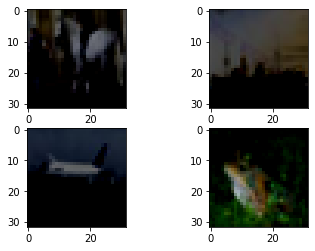

In [18]:
datagen = ImageDataGenerator(samplewise_center = True)
datagen.fit(X_train)

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size = 4, seed = 42):
  for i in range(0, 4):
    plt.subplot(220 + 1 + i)
    plt.imshow(X_batch[i])
  plt.show()
  break

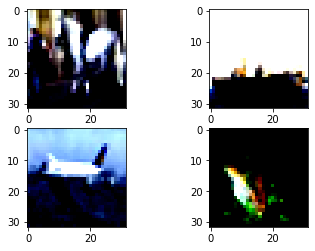

In [19]:
datagen = ImageDataGenerator(featurewise_std_normalization = True)
datagen.fit(X_train)

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size = 4, seed = 42):
  for i in range(0, 4):
    plt.subplot(220 + 1 + i)
    plt.imshow(X_batch[i])
  plt.show()
  break

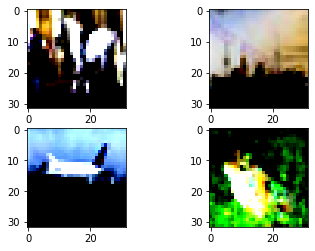

In [20]:
datagen = ImageDataGenerator(samplewise_std_normalization = True)
datagen.fit(X_train)

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size = 4, seed = 42):
  for i in range(0, 4):
    plt.subplot(220 + 1 + i)
    plt.imshow(X_batch[i])
  plt.show()
  break

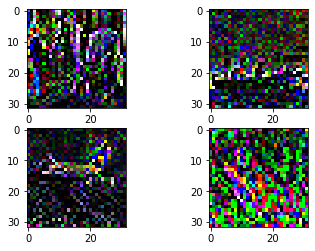

In [21]:
datagen = ImageDataGenerator(zca_whitening = True)
datagen.fit(X_train)

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size = 4, seed = 42):
  for i in range(0, 4):
    plt.subplot(220 + 1 + i)
    plt.imshow(X_batch[i])
  plt.show()
  break

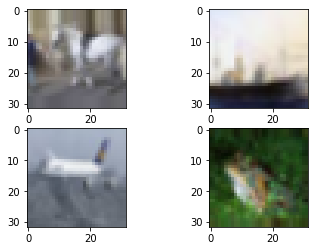

In [22]:
datagen = ImageDataGenerator(zoom_range = 0.25)
datagen.fit(X_train)

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size = 4, seed = 42):
  for i in range(0, 4):
    plt.subplot(220 + 1 + i)
    plt.imshow(X_batch[i])
  plt.show()
  break

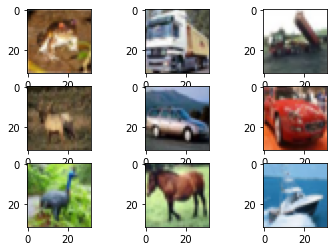

In [23]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
img_rows, img_cols, channels= 32, 32, 3

for i in range(0, 9):
  plt.subplot(330 + 1 + i)
  plt.imshow(X_train[i])
plt.show()

In [24]:
datagen = ImageDataGenerator(
    rotation_range = 15,
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.3)

datagen.fit(X_train)

In [25]:
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, channels)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_train.shape[0], 'test samples')

X_train shape: (50000, 32, 32, 3)
50000 train samples
50000 test samples


In [26]:
X_train = X_train.astype('float32')  
X_test = X_test.astype('float32')

mean = np.mean(X_train)
std = np.std(X_train)

X_test = (X_test - mean) / std
X_train = (X_train - mean) / std

num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [27]:
def plothist(hist):
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc = 'upper left')
  plt.show()

In [28]:
model_3 = Sequential()

model_3.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = (img_rows, img_cols, channels)))
model_3.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
model_3.add(MaxPooling2D(pool_size = (2, 2)))   # Reduces to 16 x 16 x 3 x num_filters

model_3.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
model_3.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
model_3.add(MaxPooling2D(pool_size = (2, 2)))   # Reduces to 8 x 8 x 3 x (2*num_filters)

model_3.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
model_3.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
model_3.add(MaxPooling2D(pool_size = (2, 2)))   # Reduces to 4 x 4 x 3 x (4*num_filters)

model_3.add(Flatten())
model_3.add(Dense(512, activation = 'relu'))
model_3.add(Dense(num_classes, activation = 'softmax'))

model_3.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                  

In [29]:
history_3 = model_3.fit(X_train,
                        y_train,
                        batch_size = 128,
                        epochs = 20,
                        validation_data = (X_test, y_test))

Epoch 1/20
391/391 [==============================] - 4s 7ms/step - loss: 1.4169 - accuracy: 0.4808 - val_loss: 1.1455 - val_accuracy: 0.5953
Epoch 2/20
391/391 [==============================] - 2s 6ms/step - loss: 0.8973 - accuracy: 0.6817 - val_loss: 0.8344 - val_accuracy: 0.7094
Epoch 3/20
391/391 [==============================] - 2s 6ms/step - loss: 0.6753 - accuracy: 0.7634 - val_loss: 0.7167 - val_accuracy: 0.7562
Epoch 4/20
391/391 [==============================] - 3s 6ms/step - loss: 0.5408 - accuracy: 0.8092 - val_loss: 0.6667 - val_accuracy: 0.7717
Epoch 5/20
391/391 [==============================] - 2s 6ms/step - loss: 0.4291 - accuracy: 0.8511 - val_loss: 0.6772 - val_accuracy: 0.7817
Epoch 6/20
391/391 [==============================] - 2s 6ms/step - loss: 0.3223 - accuracy: 0.8874 - val_loss: 0.6909 - val_accuracy: 0.7877
Epoch 7/20
391/391 [==============================] - 2s 6ms/step - loss: 0.2345 - accuracy: 0.9182 - val_loss: 0.7463 - val_accuracy: 0.7842
Epoch 

In [30]:
model_3.evaluate(X_test,
                 y_test,
                 batch_size = 128)

79/79 [==============================] - 0s 3ms/step - loss: 1.4042 - accuracy: 0.7712


[1.404166579246521, 0.7712000012397766]

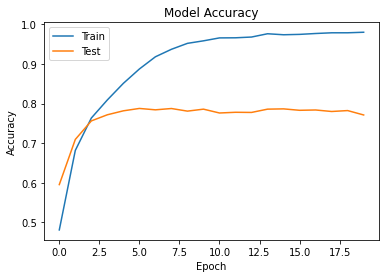

In [31]:
plothist(history_3)

# Exercise 4

Try to use what we learned during our last lecture (on regularization and optimization) to improve your model.

I suggest especially using batch normalization and early stopping (since these tools also helps you train faster).

In [32]:
model_4 = Sequential()

model_4.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = (img_rows, img_cols, channels)))
model_4.add(BatchNormalization(axis = -1))
model_4.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
model_4.add(BatchNormalization(axis = -1))
model_4.add(MaxPooling2D(pool_size = (2, 2)))   # Reduces to 16 x 16 x 3 x num_filters
model_4.add(Dropout(0.1))

model_4.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
model_4.add(BatchNormalization(axis = -1))
model_4.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
model_4.add(BatchNormalization(axis = -1))
model_4.add(MaxPooling2D(pool_size = (2, 2)))   # Reduces to 8 x 8 x 3 x (2*num_filters)
model_4.add(Dropout(0.1))

model_4.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
model_4.add(BatchNormalization(axis = -1))
model_4.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
model_4.add(BatchNormalization(axis = -1))
model_4.add(MaxPooling2D(pool_size = (2, 2)))   # Reduces to 4 x 4 x 3 x (4*num_filters)
model_4.add(Dropout(0.1))

model_4.add(Flatten())
model_4.add(Dense(512, activation = 'relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.5))
model_4.add(Dense(num_classes, activation = 'softmax'))

model_4.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                      

In [33]:
history_4 = model_4.fit_generator(datagen.flow(X_train, y_train, batch_size = 128),
                                  steps_per_epoch = len(X_train) / 128,
                                  epochs = 20,
                                  validation_data = (X_test, y_test))

Epoch 1/20
390/390 [==============================] - 29s 70ms/step - loss: 1.7766 - accuracy: 0.4195 - val_loss: 1.2606 - val_accuracy: 0.5375
Epoch 2/20
390/390 [==============================] - 27s 69ms/step - loss: 1.2463 - accuracy: 0.5590 - val_loss: 1.1198 - val_accuracy: 0.6245
Epoch 3/20
390/390 [==============================] - 27s 69ms/step - loss: 1.0489 - accuracy: 0.6284 - val_loss: 0.8441 - val_accuracy: 0.7081
Epoch 4/20
390/390 [==============================] - 27s 69ms/step - loss: 0.9360 - accuracy: 0.6679 - val_loss: 0.8209 - val_accuracy: 0.7159
Epoch 5/20
390/390 [==============================] - 27s 69ms/step - loss: 0.8720 - accuracy: 0.6933 - val_loss: 0.8997 - val_accuracy: 0.7122
Epoch 6/20
390/390 [==============================] - 27s 69ms/step - loss: 0.8138 - accuracy: 0.7170 - val_loss: 0.7333 - val_accuracy: 0.7561
Epoch 7/20
390/390 [==============================] - 27s 69ms/step - loss: 0.7620 - accuracy: 0.7321 - val_loss: 0.7253 - val_accuracy:

In [34]:
model_4.evaluate(X_test,
                 y_test,
                 batch_size = 128)

79/79 [==============================] - 0s 4ms/step - loss: 0.4460 - accuracy: 0.8514


[0.4460059702396393, 0.8514000177383423]

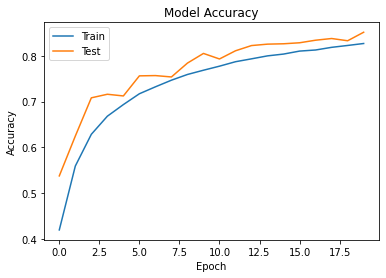

In [35]:
plothist(history_4)